In [1]:
#take slice 214

In [2]:
#Import modules

import matplotlib.pyplot as plt
from matplotlib import cm, patches
import matplotlib 
import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
import reproject as r
import os as os
#import colorce
import scipy as sp
import lic
from matplotlib.colors import SymLogNorm,LogNorm
#import seaborn as seb
import scipy.stats as st
import matplotlib.ticker as ticker
from reproject import (reproject_interp, reproject_exact)

ltgreen="#33FF99"

polthresh=3 #sn for polarization cut

In [3]:
#Needed for WCS scaling
def header_scale(fits, rebin):
    naxis1, naxis2 = fits[0].header['NAXIS1'], fits[0].header['NAXIS2']
    fits[0].header['NAXIS1'] = int(rebin * fits[0].header['NAXIS1'])
    fits[0].header['NAXIS2'] = int(rebin * fits[0].header['NAXIS2'])
    fits[0].header['CDELT1'] /= rebin
    fits[0].header['CDELT2'] /= rebin
    fits[0].header['CRPIX1'] = (fits[0].header['CRPIX1'] / naxis1) * fits[0].header['NAXIS1']
    fits[0].header['CRPIX2'] = (fits[0].header['CRPIX2'] / naxis2) * fits[0].header['NAXIS2']

In [4]:
#filenames- need to set this path to whatever file you are using
pol_filename = 'CMZ_3mm_HNCO.fits'

In [5]:
#Import pol file
file1 = fits.open(pol_filename)[0]

lic | 2024-06-27 10:06:35,096 | WARNING  | VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


In [6]:
#file1.header
#NAXIS1-3 gives x-y coords, and slices <--use this format for slices function

In [7]:
scidata1=file1.data
scidata1.shape
# scidata=scidata1[0,:,:]
# scidata.shape

#slice, y, x

(327, 165, 765)

In [8]:
w=wcs.WCS(file1.header, naxis=2) # This is the World Coordinate System of the HAWC+ fits file
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 0.541666678728  -0.0416666712776  
CRPIX : 383.0  83.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00333333353753  0.00333333353753  
NAXIS : 765  165  327

Text(0, 0.5, '214 $\\mu$m Intensity (MJy sr$^{-1}$)')

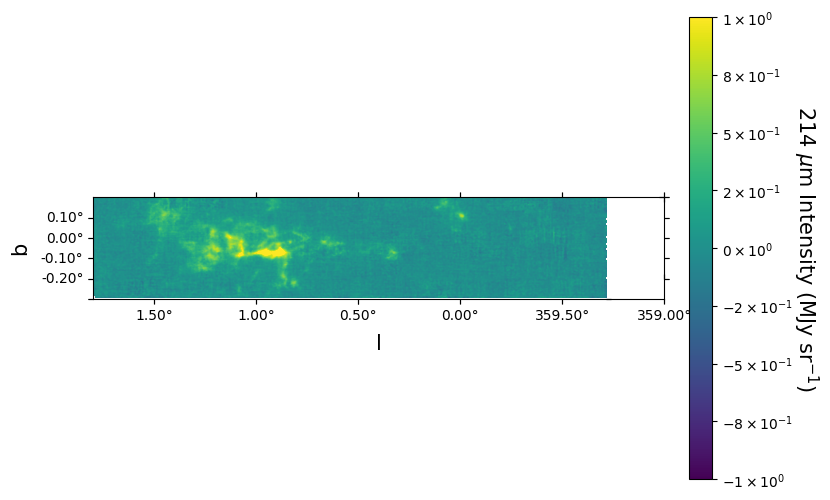

In [9]:
#Lower Left corner of final map
ll=SkyCoord('1.8deg','-.3deg')
#upper right corner of final map
ur=SkyCoord('359deg','.2deg')

plt.figure(figsize=(8,6))
ax=plt.axes(projection=w)#, slices=('x','y',214))

ra=ax.coords[0]
dec=ax.coords[1]
ra.set_major_formatter('d.dd')
dec.set_major_formatter('d.dd')
ax.set_xlabel('l', fontsize=15)
ax.set_ylabel('b', fontsize=15)
x1,y1=w.wcs_world2pix(ll.ra.deg,ll.dec.deg,0)
x2,y2=w.wcs_world2pix(ur.ra.deg,ur.dec.deg,0)
ax.set_xlim([x1,x2])
ax.set_ylim([y1,y2])

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = ax.imshow(scidata1[214,:,:], vmin=-1, vmax=1)
cb=plt.colorbar(cbar,fraction=0.039,pad=0.04,format=ticker.FuncFormatter(fmt))
cb.ax.set_ylabel('214 $\mu$m Intensity (MJy sr$^{-1}$)', rotation=270,labelpad=20, fontsize=15)

#ax.contour(file1.data, levels=[])


Text(0, 0.5, '214 $\\mu$m Intensity (MJy sr$^{-1}$)')

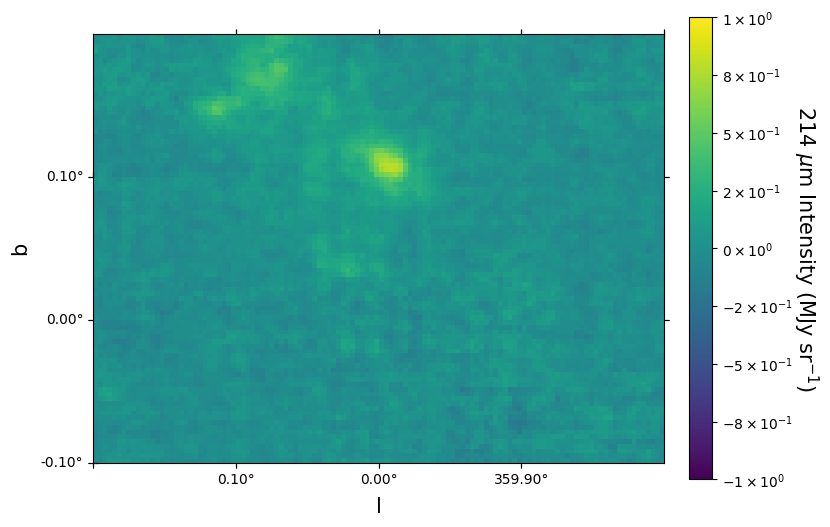

In [10]:
#region of interest

#Lower Left corner of final map
ll=SkyCoord('.2deg','-0.1deg')
#upper right corner of final map
ur=SkyCoord('359.8deg','.2deg')

plt.figure(figsize=(8,6))
ax=plt.axes(projection=w)#, slices=('x','y',214))

ra=ax.coords[0]
dec=ax.coords[1]
ra.set_major_formatter('d.dd')
dec.set_major_formatter('d.dd')
ax.set_xlabel('l', fontsize=15)
ax.set_ylabel('b', fontsize=15)
x1,y1=w.wcs_world2pix(ll.ra.deg,ll.dec.deg,0)
x2,y2=w.wcs_world2pix(ur.ra.deg,ur.dec.deg,0)
ax.set_xlim([x1,x2])
ax.set_ylim([y1,y2])

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = ax.imshow(scidata1[214,:,:], vmin=-1, vmax=1)
cb=plt.colorbar(cbar,fraction=0.039,pad=0.04,format=ticker.FuncFormatter(fmt))
cb.ax.set_ylabel('214 $\mu$m Intensity (MJy sr$^{-1}$)', rotation=270,labelpad=20, fontsize=15)

#ax.contour(file1.data, levels=[])


### Channel Map

In [11]:
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import ImageGrid 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from astropy.io import fits 
from astropy.wcs import WCS 
import numpy as np 
import matplotlib.colors as mcolors  

In [12]:
#define a class to handle velocity conversion
class Velo(object):
    def __init__(self, header):
        wcs = WCS(header)
        self.wcs_vel = wcs.sub([3])

    def to_vel(self, p):
        v = self.wcs_vel.pixel_to_world(p)
        return v.value

In [13]:
rotated=fits.open('Merged_Full_Polarization_Rotated.fits')

In [14]:
w_fixed=wcs.WCS(rotated[0].header) #coord system from rotated SOFIA image

In [15]:
#Use SOFIA map as a background image
pixsize=rotated[0].header['CDELT2']*3600 #picks out the plate scale and converts to arcsec/pixel
print(pixsize)
beamdiam=5.3/3600 #arcseconds
bunit=rotated[0].header['BUNIT']
I = rotated['Stokes I'].data
sigI = rotated['ERROR I'].data
if bunit=='Jy/pixel':
    beam_area=(float(pixsize)/3600*np.pi/180)**2 #in sr
else:
    beam_area=(float(beamdiam)/3600*np.pi/180/2)**2*np.pi #in sr
I=I/beam_area/1e6 #scale to MJy/sr here and it should follow through the analysis.
sigI=sigI/beam_area/1e6

4.550000000000001


In [16]:
pol, pol_err, ang = rotated['DEBIASED PERCENT POL'].data, rotated['ERROR PERCENT POL'].data, rotated['POL ANGLE'].data

In [17]:
#fixing all the polarized stuff to match the new coord system/pixel orientation
pol_fixed,_=reproject_interp((pol,w_fixed),rotated[0].header)
pol_error_fixed,_=reproject_interp((pol_err,w_fixed),rotated[0].header)
pol_ang_fixed,_=reproject_interp((ang,w_fixed),rotated[0].header)

I_fixed,_=reproject_interp((I,w_fixed),rotated[0].header)
sigI_fixed,_=reproject_interp((sigI,w_fixed),rotated[0].header)

In [18]:
#3 sigma threshold
polthresh=3
pol_fixed[np.where(pol_fixed/pol_error_fixed<polthresh)]=np.nan
pol_fixed[np.where(I_fixed/sigI_fixed<200)]=np.nan
pol_fixed[np.where(pol_fixed>50)]=np.nan

In [19]:
#polarization vector spacing, default 2, raise if code is slow
skip=5
aa = pol_fixed[~np.isnan(pol_fixed)] 
#aa[aa > 0]
print(len(aa))
x, y = np.meshgrid(np.arange(pol_fixed.shape[1]), np.arange(pol_fixed.shape[0]))
mask=np.where((x%skip+y%skip)==0)
#apply the mask
pol2=pol_fixed[mask]
ang2=pol_ang_fixed[mask]
xnew=x[mask]
ynew=y[mask]

print(np.nanmin(ang2))
print(np.nanmax(ang2))

#Coords required for quiver
xx = pol2*np.cos(ang2*np.pi/180.)
yy = pol2*np.sin(ang2*np.pi/180.)
#print(np.nanmin(pol2))
temp1=ang2*np.pi/180.
print(np.nanmin(temp1))
print(np.nanmax(temp1))

260971
-26.999164156295695
152.99346015508036
-0.4712243098137968
2.6702396137249065


In [20]:
HNCO_fixed,_ = reproject_interp((file1.data[205:229,:,:],w),rotated[0].header)

In [21]:
#set up axes and colorbar
def setup_axes(fig, header):
    wcs = WCS(header)
    g = ImageGrid(fig, 111,
                            nrows_ncols=(5, 5), #grid rows and columns
                            ngrids=None,
                            direction='row',
                            axes_pad=0.02, #distance between axes
                            share_all=True, aspect=True,
                            label_mode='L', cbar_mode=None)
   
    # make colorbar
    ax = g[-1]
    cax = inset_axes(ax,
                     width="8%", # width = 10% of parent_bbox width
                     height="100%", # height : 50%
                     loc=3,
                     bbox_to_anchor=(1.01, 0, 1, 1),
                     bbox_transform=ax.transAxes,
                     borderpad=0.
                     )

    return g, cax

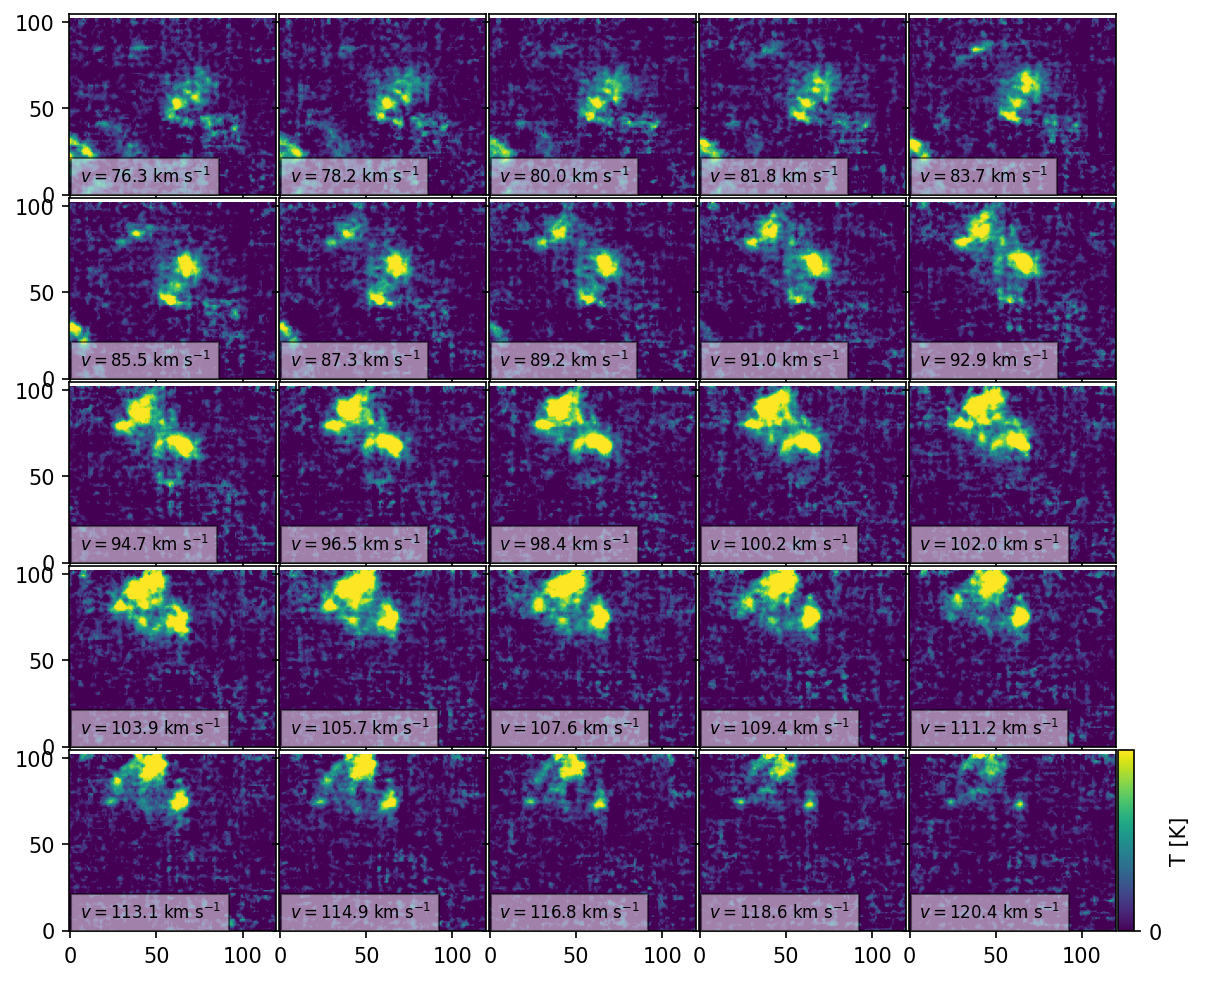

In [95]:
#Lower Left corner of final map
ll=SkyCoord('0.06deg','0.05deg')
#upper right corner of final map
ur=SkyCoord('359.925deg','.19deg')

header = file1.header
vel = Velo(header)

fig = plt.figure(1, figsize=(9, 12), dpi=150)
g, cax = setup_axes(fig, header)




cmap = plt.cm.viridis
norm = mcolors.Normalize()
images = []
channel_number = 205

#loop through each grid and plot the next channel
for i, ax in enumerate(g):
    channel = file1.data[channel_number]
    im = ax.imshow(channel[60:, 480:600], origin="lower", cmap=cmap, vmin=0, vmax=.3)
    images.append(im)
    v = vel.to_vel(channel_number)/ 1.e3
    t = ax.text(0.05, 0.05, r"$v=%4.1f$ km s$^{-1}$" % (v), transform=ax.transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white',alpha=0.5))
    channel_number += 1


# make colorbar
cb = plt.colorbar(im, cax=cax)
cb.set_label("T [K]")
cb.set_ticks([0, 1, 2, 3])

# adjust norm
# norm.vmin = -1
# norm.vmax = 1.5
for im in images:
    im.changed()

plt.show()

In [66]:
from spectral_cube import SpectralCube
import math
from astropy import units as u

In [44]:
cube = SpectralCube.read('CMZ_3mm_HNCO.fits')

lic | 2024-06-27 10:17:55,071 | WARNING  | VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


In [46]:
w=wcs.WCS(cube[0].header)

In [119]:
cube.spectral_axis #default unit of m/s

<Quantity [-300448.92503912, -298611.03167732, -296773.13831552,
           -294935.24495372, -293097.35159192, -291259.45823012,
           -289421.56486832, -287583.67150652, -285745.77814472,
           -283907.88478292, -282069.99142112, -280232.09805932,
           -278394.20469752, -276556.31133572, -274718.41797392,
           -272880.52461212, -271042.63125032, -269204.73788852,
           -267366.84452672, -265528.95116492, -263691.05780312,
           -261853.16444132, -260015.27107952, -258177.37771772,
           -256339.48435592, -254501.59099412, -252663.69763232,
           -250825.80427052, -248987.91090872, -247150.01754692,
           -245312.12418512, -243474.23082332, -241636.33746152,
           -239798.44409972, -237960.55073792, -236122.65737612,
           -234284.76401432, -232446.87065252, -230608.97729072,
           -228771.08392892, -226933.19056712, -225095.29720532,
           -223257.40384352, -221419.51048172, -219581.61711992,
           -217743.723758

In [122]:
clip_cube= cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=cube.header['RESTFREQ']*u.Hz)

In [123]:
clip_cube.spectral_axis

<Quantity [-300.75033394, -298.9087625 , -297.06721366, -295.22568742,
           -293.38418378, -291.54270275, -289.70124431, -287.85980848,
           -286.01839524, -284.1770046 , -282.33563656, -280.49429113,
           -278.65296828, -276.81166804, -274.97039039, -273.12913534,
           -271.28790289, -269.44669303, -267.60550577, -265.7643411 ,
           -263.92319903, -262.08207955, -260.24098266, -258.39990837,
           -256.55885667, -254.71782756, -252.87682105, -251.03583713,
           -249.19487579, -247.35393705, -245.5130209 , -243.67212734,
           -241.83125637, -239.99040799, -238.1495822 , -236.30877899,
           -234.46799838, -232.62724035, -230.78650491, -228.94579205,
           -227.10510178, -225.2644341 , -223.423789  , -221.58316649,
           -219.74256656, -217.90198922, -216.06143446, -214.22090228,
           -212.38039269, -210.53990567, -208.69944124, -206.8589994 ,
           -205.01858013, -203.17818345, -201.33780934, -199.49745782,
      

In [134]:
clip_subcube = clip_cube.spectral_slab(70*u.km/u.s, 130*u.km/u.s) #going a bit above and below limits

In [135]:
clip_subcube.spectral_axis

<Quantity [ 70.78881501,  72.62582927,  74.46282101,  76.29979023,
            78.13673693,  79.97366111,  81.81056278,  83.64744194,
            85.48429857,  87.32113269,  89.1579443 ,  90.99473339,
            92.83149997,  94.66824404,  96.50496559,  98.34166463,
           100.17834115, 102.01499517, 103.85162667, 105.68823566,
           107.52482214, 109.36138611, 111.19792757, 113.03444652,
           114.87094296, 116.70741689, 118.54386832, 120.38029723,
           122.21670364, 124.05308755, 125.88944894, 127.72578783,
           129.56210421] km / s>

In [151]:
clip_moment_0 = clip_subcube.moment(order=2)
clip_moment_0.write('clipped_moment0.fits', overwrite=True)

lic | 2024-06-27 11:02:05,914 | WARNING  | VarianceWarning: Note that the second moment returned will be a variance map. To get a linewidth map, use the SpectralCube.linewidth_fwhm() or SpectralCube.linewidth_sigma() methods instead.
/users/nsalem/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/users/nsalem/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /
lic | 2024-06-27 11:02:06,148 | WARNING  | VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


In [152]:
clipped_cube = fits.open('clipped_moment0.fits')

In [153]:
clipped_cube[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  765                                                  
NAXIS2  =                  165                                                  
BLANK   =                   -1  /                                               
BUNIT   = 'km2 s-2 '                                                            
CELLSCAL= 'CONSTANT'  /                                                         
RESTFREQ=    8.79252380000E+10  /                                               
BMAJ    =    1.08300000429E-02  /                                               
BMIN    =    1.08300000429E-02  /                                               
DATAMIN =   -4.48273086548E+00  /                                               
DATAMAX =    5.07270288467E+

Text(0.5, 1.0, 'Moment 2 Map')

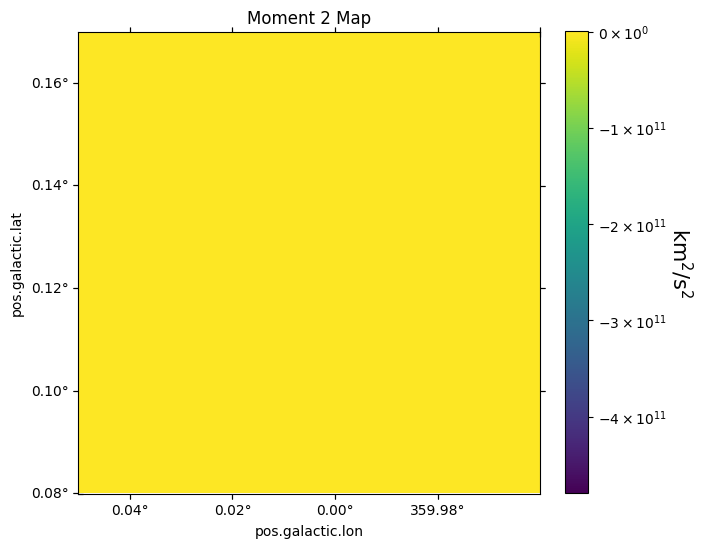

In [154]:
#Lower Left corner of final map
ll=SkyCoord('0.05deg','0.08deg')
#upper right corner of final map
ur=SkyCoord('359.96deg','.17deg')

plt.figure(figsize=(8,6))
ax=plt.axes(projection=w)#, slices=('x','y',214))

ra=ax.coords[0]
dec=ax.coords[1]
ra.set_major_formatter('d.dd')
dec.set_major_formatter('d.dd')
# ax.set_xlabel('l', fontsize=15)
# ax.set_ylabel('b', fontsize=15)
x1,y1=w.wcs_world2pix(ll.ra.deg,ll.dec.deg,0)
x2,y2=w.wcs_world2pix(ur.ra.deg,ur.dec.deg,0)
ax.set_xlim([x1,x2])
ax.set_ylim([y1,y2])

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = ax.imshow(clipped_cube[0].data)#, vmin=-10, vmax=6e2)
cb=plt.colorbar(cbar,fraction=0.039,pad=0.04,format=ticker.FuncFormatter(fmt))
cb.ax.set_ylabel('km$^2$/s$^2$', rotation=270,labelpad=20, fontsize=15)
ax.set_title('Moment 2 Map')